In [1]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [3]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [5]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [6]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [7]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [8]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [9]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=20, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [10]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=True)
    model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                    metrics=['accuracy'])
    
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=sgd,
#                   metrics=['accuracy'])
    return model



In [11]:
#def myAngleCV(X_train, X_angle, X_test):
K=7
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=100,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/100
24/24 [==============================] - 20s 840ms/step - loss: 0.6489 - acc: 0.6182 - val_loss: 0.4599 - val_acc: 0.7870
Epoch 2/100
24/24 [==============================] - 14s 599ms/step - loss: 0.4007 - acc: 0.8082 - val_loss: 0.3415 - val_acc: 0.8217
Epoch 3/100
24/24 [==============================] - 14s 600ms/step - loss: 0.3467 - acc: 0.8429 - val_loss: 0.2531 - val_acc: 0.8739
Epoch 4/100
24/24 [==============================] - 14s 603ms/step - loss: 0.2897 - acc: 0.8689 - val_loss: 0.2477 - val_acc: 0.8739
Epoch 5/100
24/24 [==============================] - 14s 603ms/step - loss: 0.2861 - acc: 0.8702 - val_loss: 0.2116 - val_acc: 0.9043
Epoch 6/100
24/24 [==============================] - 13s 525ms/step - loss: 0.2462 - acc: 0.8983 - val_loss: 0.2263 - val_acc: 0.9043
Epoch 7/100
24/24 [==============================] - 13s 528ms/step - loss: 0.2670 - acc: 0.8877 - val_loss: 0.2550 - val_acc: 0.8783
Epoch 8/100
24/24 [===============

24/24 [==============================] - 13s 535ms/step - loss: 0.2219 - acc: 0.9006 - val_loss: 0.2030 - val_acc: 0.9087
Epoch 16/100
24/24 [==============================] - 13s 536ms/step - loss: 0.2580 - acc: 0.8917 - val_loss: 0.1871 - val_acc: 0.9348
Epoch 17/100
24/24 [==============================] - 13s 537ms/step - loss: 0.2375 - acc: 0.8982 - val_loss: 0.1731 - val_acc: 0.9304
Epoch 18/100
24/24 [==============================] - 13s 536ms/step - loss: 0.1989 - acc: 0.9113 - val_loss: 0.1942 - val_acc: 0.9130
Epoch 19/100
24/24 [==============================] - 13s 536ms/step - loss: 0.2042 - acc: 0.9236 - val_loss: 0.1706 - val_acc: 0.9130
Epoch 20/100
24/24 [==============================] - 13s 535ms/step - loss: 0.1937 - acc: 0.9158 - val_loss: 0.1901 - val_acc: 0.9261
Epoch 21/100
24/24 [==============================] - 13s 536ms/step - loss: 0.2013 - acc: 0.9202 - val_loss: 0.2225 - val_acc: 0.9087
Epoch 22/100
24/24 [==============================] - 13s 529ms/step

Epoch 41/100
24/24 [==============================] - 13s 533ms/step - loss: 0.0988 - acc: 0.9576 - val_loss: 0.2831 - val_acc: 0.9130
Epoch 42/100
24/24 [==============================] - 13s 531ms/step - loss: 0.1286 - acc: 0.9517 - val_loss: 0.2490 - val_acc: 0.9087
Train loss: 0.155706448131
Train accuracy: 0.935953422752
Test loss: 0.186535130506
Test accuracy: 0.930434783645

===================FOLD= 3
Epoch 1/100
24/24 [==============================] - 16s 674ms/step - loss: 0.6671 - acc: 0.6783 - val_loss: 0.4275 - val_acc: 0.7565
Epoch 2/100
24/24 [==============================] - 15s 618ms/step - loss: 0.4246 - acc: 0.8029 - val_loss: 0.1832 - val_acc: 0.9391
Epoch 3/100
24/24 [==============================] - 13s 537ms/step - loss: 0.3495 - acc: 0.8504 - val_loss: 0.1908 - val_acc: 0.9391
Epoch 4/100
24/24 [==============================] - 15s 617ms/step - loss: 0.3499 - acc: 0.8327 - val_loss: 0.1820 - val_acc: 0.9435
Epoch 5/100
24/24 [==============================] -

Epoch 11/100
24/24 [==============================] - 13s 530ms/step - loss: 0.2159 - acc: 0.9076 - val_loss: 0.2831 - val_acc: 0.8728
Epoch 12/100
24/24 [==============================] - 13s 537ms/step - loss: 0.1686 - acc: 0.9238 - val_loss: 0.4338 - val_acc: 0.8728
Epoch 13/100
24/24 [==============================] - 13s 537ms/step - loss: 0.1893 - acc: 0.9231 - val_loss: 0.3430 - val_acc: 0.8772
Epoch 14/100
24/24 [==============================] - 13s 536ms/step - loss: 0.2264 - acc: 0.9134 - val_loss: 0.2694 - val_acc: 0.9035
Epoch 15/100
24/24 [==============================] - 15s 617ms/step - loss: 0.1721 - acc: 0.9290 - val_loss: 0.2496 - val_acc: 0.9211
Epoch 16/100
24/24 [==============================] - 13s 537ms/step - loss: 0.1502 - acc: 0.9414 - val_loss: 0.3780 - val_acc: 0.8728
Epoch 17/100
24/24 [==============================] - 13s 536ms/step - loss: 0.1528 - acc: 0.9368 - val_loss: 0.3339 - val_acc: 0.9123
Epoch 18/100
24/24 [==============================] - 1

Epoch 36/100
24/24 [==============================] - 13s 534ms/step - loss: 0.1469 - acc: 0.9446 - val_loss: 0.2316 - val_acc: 0.8816
Epoch 37/100
24/24 [==============================] - 13s 536ms/step - loss: 0.1203 - acc: 0.9551 - val_loss: 0.2678 - val_acc: 0.8728
Epoch 38/100
24/24 [==============================] - 15s 616ms/step - loss: 0.1385 - acc: 0.9401 - val_loss: 0.2156 - val_acc: 0.9079
Epoch 39/100
24/24 [==============================] - 13s 534ms/step - loss: 0.1179 - acc: 0.9492 - val_loss: 0.2308 - val_acc: 0.9035
Epoch 40/100
24/24 [==============================] - 13s 536ms/step - loss: 0.1284 - acc: 0.9538 - val_loss: 0.2194 - val_acc: 0.8991
Epoch 41/100
24/24 [==============================] - 13s 537ms/step - loss: 0.1169 - acc: 0.9551 - val_loss: 0.2635 - val_acc: 0.8947
Epoch 42/100
24/24 [==============================] - 13s 535ms/step - loss: 0.1156 - acc: 0.9511 - val_loss: 0.2359 - val_acc: 0.8991
Epoch 43/100
24/24 [==============================] - 1

Epoch 38/100
24/24 [==============================] - 13s 536ms/step - loss: 0.1501 - acc: 0.9408 - val_loss: 0.2774 - val_acc: 0.8816
Epoch 39/100
24/24 [==============================] - 13s 537ms/step - loss: 0.1297 - acc: 0.9427 - val_loss: 0.2759 - val_acc: 0.8772
Epoch 40/100
24/24 [==============================] - 13s 533ms/step - loss: 0.1116 - acc: 0.9531 - val_loss: 0.3323 - val_acc: 0.8904
Epoch 41/100
24/24 [==============================] - 13s 534ms/step - loss: 0.1302 - acc: 0.9466 - val_loss: 0.3654 - val_acc: 0.8509
Epoch 42/100
24/24 [==============================] - 13s 535ms/step - loss: 0.1393 - acc: 0.9446 - val_loss: 0.3004 - val_acc: 0.8509
Epoch 43/100
24/24 [==============================] - 13s 534ms/step - loss: 0.1225 - acc: 0.9512 - val_loss: 0.2536 - val_acc: 0.9035
Epoch 44/100
24/24 [==============================] - 13s 526ms/step - loss: 0.1297 - acc: 0.9466 - val_loss: 0.3818 - val_acc: 0.8640
Epoch 45/100
24/24 [==============================] - 1

In [12]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [13]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_Adam_7folds_amsgrad_0001_20p.csv', index=False)

dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


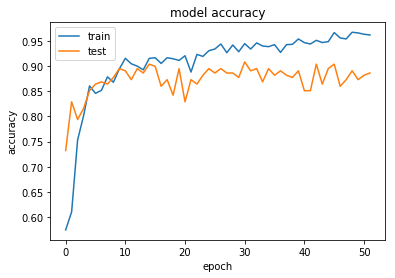

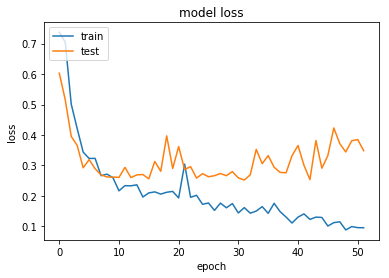

In [14]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

In [15]:
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [16]:
Y_holdout

13      1
14      0
26      1
38      1
43      0
44      0
52      0
80      0
104     1
127     0
137     0
138     1
141     1
167     1
180     0
186     0
195     1
199     0
206     1
207     1
212     0
213     1
217     0
221     0
234     1
240     0
256     0
267     1
274     1
276     1
       ..
1417    0
1435    0
1440    1
1445    1
1447    1
1460    1
1465    0
1466    0
1468    0
1470    0
1488    0
1489    1
1495    0
1504    1
1516    0
1525    0
1533    0
1537    0
1539    0
1541    0
1542    0
1549    0
1552    0
1559    0
1566    0
1567    0
1577    0
1590    0
1597    0
1602    0
Name: is_iceberg, Length: 228, dtype: int64

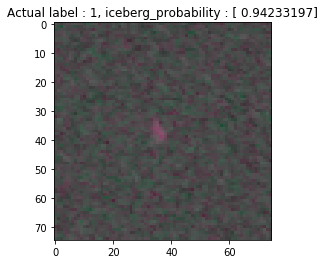

In [17]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[13])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

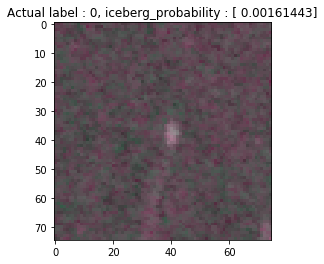

In [18]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

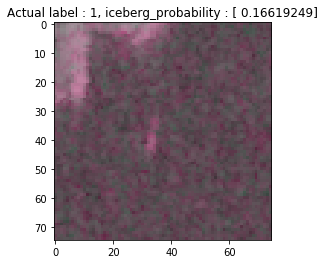

In [19]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[26])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

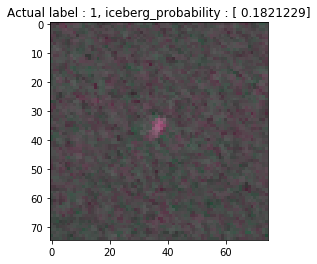

In [20]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[38])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)

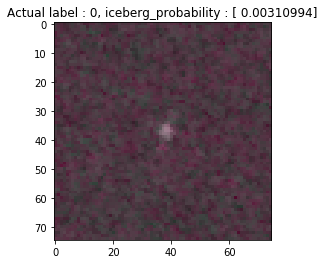

In [21]:
plt.imshow(X_holdout2[4], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[43])+ ","+" iceberg_probability : "+str(pred_valid[4])
plt.title(tl)

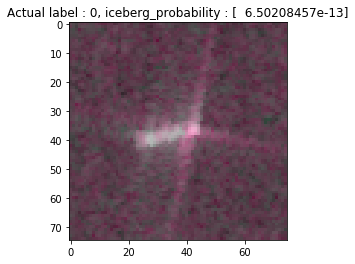

In [22]:
plt.imshow(X_holdout2[5], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[44])+ ","+" iceberg_probability : "+str(pred_valid[5])
plt.title(tl)

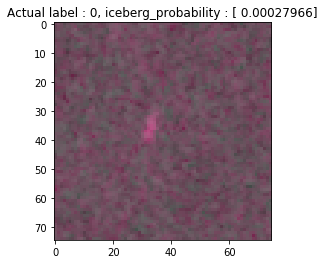

In [23]:
plt.imshow(X_holdout2[6], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[52])+ ","+" iceberg_probability : "+str(pred_valid[6])
plt.title(tl)

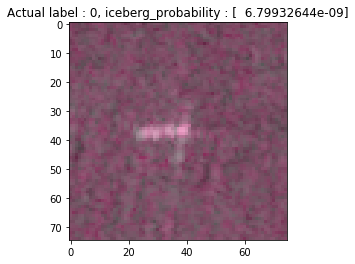

In [24]:
plt.imshow(X_holdout2[7], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[80])+ ","+" iceberg_probability : "+str(pred_valid[7])
plt.title(tl)

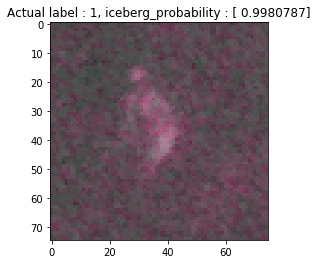

In [25]:
plt.imshow(X_holdout2[8], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[104])+ ","+" iceberg_probability : "+str(pred_valid[8])
plt.title(tl)

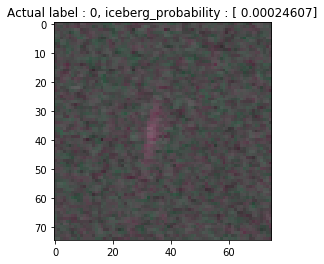

In [26]:
plt.imshow(X_holdout2[9], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[127])+ ","+" iceberg_probability : "+str(pred_valid[9])
plt.title(tl)